# PRE-PROCESSING (ORIGINAL DATA)
In this notebook the pre-processing of the original dataset takes place. The only difference wrt the *'features_ring.zip'* file is the presence of the *same_chain* feature extracted in the *Feature Extraction* file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

In [ ]:
# Set Pandas to display all columns
pd.set_option('display.max_columns', None)

Custom functions to load tsv files into dataframes and viceversa are defined:

In [ ]:
def load_tsv_as_df(folder, filename):
    if not filename.endswith('.tsv'):
        filename += '.tsv'
    path = os.path.join(folder, filename)
    df = pd.read_csv(path, sep='\t')
    return df

In [ ]:
def save_df_as_tsv(df, folder, filename):
    os.makedirs(folder, exist_ok=True)
    if not filename.endswith('.tsv'):
        filename += '.tsv'
    path = os.path.join(folder, filename)
    df.to_csv(path, sep='\t', index=False)
    print(f"Saved TSV to: {path}")

# Data Loading
The tsv file is loaded directly into a pandas dataframe using the custom function defined above.

In [ ]:
# Specify your folder path
folder_path = '/content/drive/MyDrive'

# Path to the TSV file
tsv_path = f'{folder_path}/Structural Bioinfo PROJECT/datasets'

# Load df
combined_df = load_tsv_as_df(tsv_path, 'combinated_df_origin.tsv')

In [ ]:
# Show the result
print("Shape of the dataset:", combined_df.shape)
combined_df.head()

Shape of the dataset: (2968986, 33)


,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,s_3di_state,s_3di_letter,t_ch,t_resi,t_ins,t_resn,t_ss8,t_rsa,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,t_3di_letter,Interaction,same_chain
0,1b0y,A,28,,R,H,0.056,-1.127,-0.711,1.538,-0.055,1.502,0.440,2.897,13.0,N,A,31,,A,H,0.434,-1.221,-0.526,-0.591,-1.302,-0.733,1.570,-0.146,9.0,J,VDW,1
1,1b0y,A,27,,E,S,0.531,-1.622,0.483,1.357,-1.453,1.477,0.113,-0.837,1.0,B,A,31,,A,H,0.434,-1.221,-0.526,-0.591,-1.302,-0.733,1.570,-0.146,9.0,J,HBOND,1
2,1b0y,A,47,,Q,T,0.460,-0.986,-0.566,0.931,-0.179,-3.005,-0.503,-1.853,13.0,N,A,84,,A,P,0.472,-1.557,2.544,-0.591,-1.302,-0.733,1.570,-0.146,2.0,C,HBOND,1
3,1b0y,A,40,,E,G,0.546,-1.860,-0.062,1.357,-1.453,1.477,0.113,-0.837,12.0,M,A,45,,N,G,0.274,-1.941,0.412,0.945,0.828,1.299,-0.169,0.933,13.0,N,HBOND,1
4,1b0y,A,37,,P,-,0.551,-0.880,2.320,0.189,2.081,-1.628,0.421,-1.392,14.0,O,A,40,,E,G,0.546,-1.860,-0.062,1.357,-1.453,1.477,0.113,-0.837,12.0,M,HBOND,1


The "MISSING" value is assigned to the interaction labels that are missing/unclassified.

In [ ]:
combined_df['Interaction'] = combined_df['Interaction'].fillna('MISSING')
combined_df['Interaction'] = combined_df['Interaction'].astype('category')
combined_df['Interaction'].cat.categories.tolist()

['HBOND',
 'IONIC',
 'MISSING',
 'PICATION',
 'PIHBOND',
 'PIPISTACK',
 'SSBOND',
 'VDW']

# Exploratory Data Analysis and Preprocessing

## Labels distribution
First, we take a look at the labels distribution in the dataset by plotting their absolute frequencies.

/tmp/ipython-input-9-2697509228.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


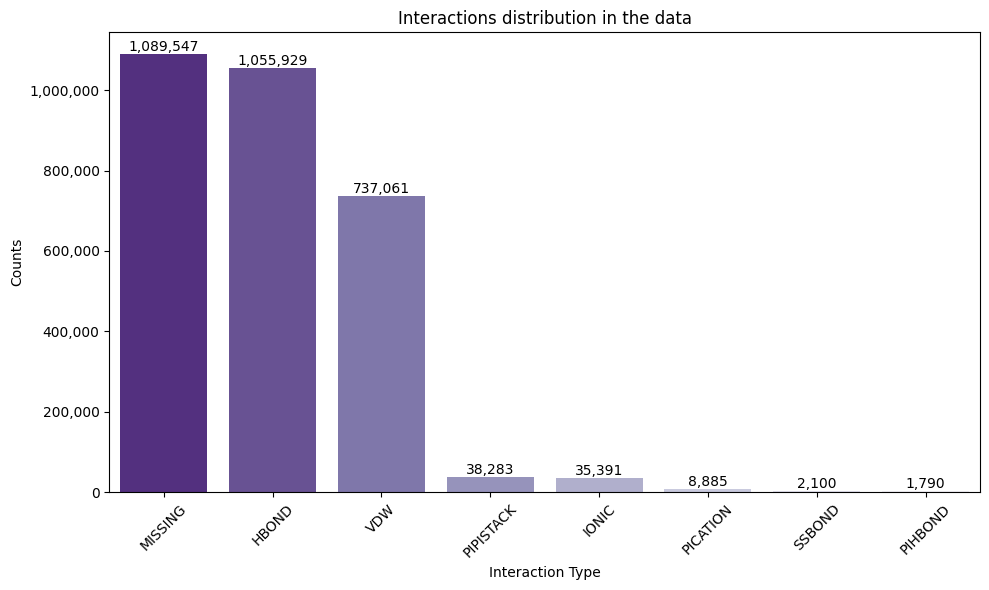

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=combined_df,
    x='Interaction',
    order=combined_df['Interaction'].value_counts().index,
    palette='Purples_r'
)

ax.set(title='Interactions distribution in the data',
       xlabel='Interaction Type',
       ylabel='Counts')

plt.xticks(rotation=45)

# Format y-axis without scientific notation
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Add counts above bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

The bar plot clearly showcases heavy imbalance in classes distribution, with the most frequent classes having a number of observations 3 orders of magnitude larger than the most rare ones. This poses specific challenges when trying to train a classification model that will be handled later in this notebook.

## Missing values

The number of missing counts per feature and the features with missing values are displayed.

In [ ]:
missing_counts = combined_df.isnull().sum()
print(missing_counts[missing_counts > 0])

s_ss8              31
s_rsa              63
s_phi           17807
s_psi            6736
s_3di_state     37025
s_3di_letter    37025
t_ss8              56
t_rsa              75
t_phi            6167
t_psi           21474
t_3di_state     44036
t_3di_letter    44036
dtype: int64


In order to assess what interaction types the missing values are falling into (MAR, MCAR, MNAR) we check the frequency of missing values in each interaction type to spot any sort of bias towards one or more labels:

In [ ]:
# Percentage of missing values per column, grouped by Interaction
missing_pct_by_interaction = combined_df.groupby('Interaction').apply(lambda g: g.isnull().mean() * 100).round(2)
print(missing_pct_by_interaction)

/tmp/ipython-input-11-2430425720.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_pct_by_interaction = combined_df.groupby('Interaction').apply(lambda g: g.isnull().mean() * 100).round(2)


             pdb_id  s_ch  s_resi  s_ins  s_resn  s_ss8  s_rsa  s_phi  s_psi  \
Interaction                                                                    
HBOND           0.0   0.0     0.0    0.0     0.0    0.0   0.00   0.56   0.25   
IONIC           0.0   0.0     0.0    0.0     0.0    0.0   0.00   0.57   0.28   
MISSING         0.0   0.0     0.0    0.0     0.0    0.0   0.01   0.63   0.21   
PICATION        0.0   0.0     0.0    0.0     0.0    0.0   0.00   0.46   0.28   
PIHBOND         0.0   0.0     0.0    0.0     0.0    0.0   0.00   0.78   0.22   
PIPISTACK       0.0   0.0     0.0    0.0     0.0    0.0   0.00   0.40   0.30   
SSBOND          0.0   0.0     0.0    0.0     0.0    0.0   0.00   1.05   0.19   
VDW             0.0   0.0     0.0    0.0     0.0    0.0   0.00   0.63   0.22   

             s_a1  s_a2  s_a3  s_a4  s_a5  s_3di_state  s_3di_letter  t_ch  \
Interaction                                                                  
HBOND         0.0   0.0   0.0   0.0   0.0  

/tmp/ipython-input-11-2430425720.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_pct_by_interaction = combined_df.groupby('Interaction').apply(lambda g: g.isnull().mean() * 100).round(2)


Results show that no strong relationship seems to occur between the missing values amount and interaction types. SSBOND interactions are the only type which seems to be consistently associated to a slighlty larger number of missing values. Despite this, we assume values to be missing completely at random (no bias towards some labels). For this reason we decide to opt for a complete case analysis, i.e. drop all incomplete observations.

In [ ]:
combined_df = combined_df.dropna()

In [ ]:
interaction_counts = combined_df['Interaction'].value_counts()
print(interaction_counts)

Interaction
MISSING      1061992
HBOND        1027525
VDW           716942
PIPISTACK      37344
IONIC          34306
PICATION        8576
SSBOND          2018
PIHBOND         1724
Name: count, dtype: int64


The resulting full dataset is still quite large, with almost 3M datapoints.

In [ ]:
total_interactions = interaction_counts.sum()
print(f"Total number of interactions: {total_interactions}")

Total number of interactions: 2890427


## Features removal

Some features are discarded for computational efficieny based on the perceived usefulness for the training process:
* *3di_letter* is discarded for both source and target as it is redundant with *3di_state*;
* insertion codes for both source and target residues are excluded as they don't carry much bio-physically meaningful information;
* *pdb_id* is removed as it does not contain relevant structural information;
* chain IDs are substituted with the additional feature.

For the moment we only drop *3di_letter* as the other features are required for further pre-processing steps.

In [ ]:
combined_df.drop(columns=['s_3di_letter', 't_3di_letter'], inplace=True)

Categorical variables are promptly encoded as so:

In [ ]:
categorical_cols = ['s_ch', 't_ch', 's_resn', 't_resn', 's_ins', 't_ins', 's_ss8', 't_ss8', 's_3di_state', 't_3di_state']

# Convert specified columns to 'category' dtype
combined_df[categorical_cols] = combined_df[categorical_cols].astype('category')

In [ ]:
combined_df.describe(include='all')

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,s_3di_state,t_ch,t_resi,t_ins,t_resn,t_ss8,t_rsa,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,Interaction,same_chain
count,2890427,2890427,2.890427e+06,2890427,2890427,2890427,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2890427.0,2890427,2.890427e+06,2890427,2890427,2890427,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2.890427e+06,2890427.0,2890427,2.890427e+06
unique,3914,60,NaN,12,20,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,60,NaN,12,20,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,8,NaN
top,4v4m,A,NaN,,L,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,A,NaN,,L,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,MISSING,NaN
freq,18390,1717699,NaN,2890207,264260,1193808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,487232.0,1645195,NaN,2890189,271803,1169200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549523.0,1061992,NaN
mean,NaN,NaN,2.077877e+02,NaN,NaN,NaN,1.703607e-01,-1.390787e+00,5.984616e-01,2.310961e-02,-8.797397e-02,-6.421588e-02,2.831879e-01,-5.684843e-02,NaN,NaN,2.427583e+02,NaN,NaN,NaN,1.816245e-01,-1.372068e+00,5.952587e-01,3.165978e-02,-1.276654e-01,2.729052e-02,2.750732e-01,4.092882e-02,NaN,NaN,9.591766e-01
std,NaN,NaN,2.464342e+02,NaN,NaN,NaN,1.999910e-01,7.609791e-01,1.572331e+00,1.010353e+00,9.635198e-01,2.164057e+00,8.829186e-01,1.648313e+00,NaN,NaN,2.516615e+02,NaN,NaN,NaN,2.092316e-01,8.043217e-01,1.521499e+00,1.026445e+00,9.379237e-01,2.115025e+00,8.948294e-01,1.627925e+00,NaN,NaN,1.978809e-01
min,NaN,NaN,-2.400000e+01,NaN,NaN,NaN,0.000000e+00,-3.141000e+00,-3.142000e+00,-1.343000e+00,-1.524000e+00,-4.760000e+00,-2.128000e+00,-3.242000e+00,NaN,NaN,-2.700000e+01,NaN,NaN,NaN,0.000000e+00,-3.141000e+00,-3.142000e+00,-1.343000e+00,-1.524000e+00,-4.760000e+00,-2.128000e+00,-3.242000e+00,NaN,NaN,0.000000e+00
25%,NaN,NaN,6.600000e+01,NaN,NaN,NaN,7.000000e-03,-1.870000e+00,-7.270000e-01,-1.006000e+00,-9.870000e-01,-1.505000e+00,-2.770000e-01,-1.262000e+00,NaN,NaN,9.700000e+01,NaN,NaN,NaN,9.000000e-03,-1.862000e+00,-7.120000e-01,-1.006000e+00,-9.870000e-01,-1.505000e+00,-2.770000e-01,-9.120000e-01,NaN,NaN,1.000000e+00
50%,NaN,NaN,1.420000e+02,NaN,NaN,NaN,8.500000e-02,-1.218000e+00,-2.740000e-01,-2.280000e-01,-2.790000e-01,5.330000e-01,3.930000e-01,-1.460000e-01,NaN,NaN,1.810000e+02,NaN,NaN,NaN,9.500000e-02,-1.249000e+00,-1.680000e-01,-2.280000e-01,-2.790000e-01,5.330000e-01,3.930000e-01,-1.460000e-01,NaN,NaN,1.000000e+00
75%,NaN,NaN,2.660000e+02,NaN,NaN,NaN,2.870000e-01,-1.078000e+00,2.306000e+00,9.450000e-01,4.650000e-01,1.502000e+00,1.045000e+00,1.313000e+00,NaN,NaN,3.070000e+02,NaN,NaN,NaN,3.020000e-01,-1.087000e+00,2.294000e+00,9.450000e-01,3.260000e-01,1.502000e+00,1.045000e+00,1.313000e+00,NaN,NaN,1.000000e+00


Double check feature types:

In [ ]:
print(combined_df.dtypes)

pdb_id           object
s_ch           category
s_resi            int64
s_ins          category
s_resn         category
s_ss8          category
s_rsa           float64
s_phi           float64
s_psi           float64
s_a1            float64
s_a2            float64
s_a3            float64
s_a4            float64
s_a5            float64
s_3di_state    category
t_ch           category
t_resi            int64
t_ins          category
t_resn         category
t_ss8          category
t_rsa           float64
t_phi           float64
t_psi           float64
t_a1            float64
t_a2            float64
t_a3            float64
t_a4            float64
t_a5            float64
t_3di_state    category
Interaction    category
same_chain        int64
dtype: object


##  Missing/unclassified interactions
At the moment the dataset is very large in size and the most frequent interaction type is the unclassified one. Maintaining this dataset would likely produce a model heavily skewed in performance towards this specific label, which is of clearly lesser biological interest. In the mean time, keeping the full dataset would pose several challenges related to the size.

For these reasons we decide to remove the "MISSING" interactions completely.

To ensure proper stratification later, the "MISSING" value is also removed.

In [ ]:
# Remove observations of MISSING type
combined_df = combined_df[combined_df['Interaction'] != 'MISSING']

# Remove unused category from the column
combined_df['Interaction'] = combined_df['Interaction'].cat.remove_unused_categories()

/tmp/ipython-input-19-1772781592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Interaction'] = combined_df['Interaction'].cat.remove_unused_categories()


In [ ]:
print("Resulting dataset shape:", combined_df.shape)

Resulting dataset shape: (1828435, 31)


## Multiple interactions

 As we know, it is possible for residues to have more than one interaction type, thus the dataset might contain multiple observations referring to the same residue pair, each identifying a different interaction type between the two.

 To explore the entity of these multiple interactions we count the duplicate observations based on a subset of features that are sufficient to uniquely identify each single residues pair: the PDB ID, residues ID, residues insertion codes and chain IDs.

In [ ]:
id_cols = ['pdb_id', 's_resi', 't_resi', 's_ch', 't_ch', 's_ins', 't_ins']
combined_df[id_cols].drop_duplicates().shape

(1413221, 7)

In [ ]:
grouped_df = combined_df.groupby(id_cols, sort=False, observed=True)['Interaction'].apply(set).reset_index()

In [ ]:
grouped_df.head()

,pdb_id,s_resi,t_resi,s_ch,t_ch,s_ins,t_ins,Interaction
0,1b0y,28,31,A,A,,,{VDW}
1,1b0y,27,31,A,A,,,{HBOND}
2,1b0y,47,84,A,A,,,{HBOND}
3,1b0y,40,45,A,A,,,{HBOND}
4,1b0y,37,40,A,A,,,"{VDW, HBOND}"


In [ ]:
grouped_df.shape

(1413221, 8)

We can see that data contains approximately 1.4M unique residue pairs, the remaining $\approx$ 400K observations come from duplicates/triplicates etc.

# Train/Test Split
A 80/20 training/test sets split is implemented. Subsequently, another 80/20 split is performed to exctract a validation set.

Each split is performed following two criteria:
1. Interactions in the same PDB structure (same *pdb_id*) are maintained together in the same set, preventing structures dispersion;
2. Each split is carried out stratifying the sets based on the dominant interaction type for each PDB ID (the most frequent type in the structure) ensuring that labels proportions are conserved.

In [ ]:
# Create a summary DataFrame where each row is one pdb_id
# and is labeled with its dominant Interaction type (for stratification)
pdb_summary = combined_df.groupby('pdb_id')['Interaction'].agg(lambda x: x.mode()[0]).reset_index()

# Train-test split on pdb_ids, stratified by dominant interaction
train_pdbs, test_pdbs = train_test_split(
    pdb_summary['pdb_id'],
    test_size=0.2,
    random_state=42,
    stratify=pdb_summary['Interaction']
)

# Filter the original DataFrame based on selected pdb_ids
train_df_temp = combined_df[combined_df['pdb_id'].isin(train_pdbs)]  # temporary df
test_df = combined_df[combined_df['pdb_id'].isin(test_pdbs)]

In [ ]:
# Re-run on temporary training set summary DataFrame where each row is one pdb_id
# and is labeled with its dominant Interaction type (for stratification)
pdb_summary = train_df_temp.groupby('pdb_id')['Interaction'].agg(lambda x: x.mode()[0]).reset_index()

# Train-validation split on pdb_ids, stratified by dominant interaction
train_pdbs, val_pdbs = train_test_split(
    pdb_summary['pdb_id'],
    test_size=0.2,
    random_state=42,
    stratify=pdb_summary['Interaction']
)

# Filter the original DataFrame based on selected pdb_ids
train_df = train_df_temp[train_df_temp['pdb_id'].isin(train_pdbs)]
val_df = train_df_temp[train_df_temp['pdb_id'].isin(val_pdbs)]

The procedure ultimately yields a 64/16/20 training/validation/test split:

In [ ]:
print("Shape of Train dataset:", train_df.shape)
print("Shape of Test dataset:", test_df.shape)
print("Shape of Validation dataset:", val_df.shape)

Shape of Train dataset: (1172244, 31)
Shape of Test dataset: (357199, 31)
Shape of Validation dataset: (298992, 31)


In [ ]:
df_split = []
for df in [train_df, val_df, test_df]:
    df_split.append(round(df.shape[0] / combined_df.shape[0], 2))
print("Split sizes: {}".format(df_split))

Split sizes: [0.64, 0.16, 0.2]


Double check stratification:

In [ ]:
total_interaction_counts = train_df['Interaction'].value_counts() + test_df['Interaction'].value_counts() + val_df['Interaction'].value_counts()

train_interaction_counts = train_df['Interaction'].value_counts() / total_interaction_counts
print("Training Set -", train_interaction_counts, "\n")
val_interaction_counts = val_df['Interaction'].value_counts() / total_interaction_counts
print("Validation set -", val_interaction_counts, "\n")
test_interaction_counts = test_df['Interaction'].value_counts() / total_interaction_counts
print("Test set -", test_interaction_counts)

Training Set - Interaction
HBOND        0.642721
VDW          0.639639
PIPISTACK    0.627919
IONIC        0.642657
PICATION     0.638410
SSBOND       0.591675
PIHBOND      0.628190
Name: count, dtype: float64 

Validation set - Interaction
HBOND        0.162724
VDW          0.164193
PIPISTACK    0.165301
IONIC        0.167638
PICATION     0.167211
SSBOND       0.203667
PIHBOND      0.175754
Name: count, dtype: float64 

Test set - Interaction
HBOND        0.194555
VDW          0.196168
PIPISTACK    0.206780
IONIC        0.189704
PICATION     0.194380
SSBOND       0.204658
PIHBOND      0.196056
Name: count, dtype: float64


# Data augmentation and encoding


# Training set

In [ ]:
train_df.shape

(1172244, 31)

Features and target are separated for next steps:

In [ ]:
# Separate features and target
X_train = train_df.drop(columns=['Interaction'])  # features
y_train = train_df['Interaction']  # target

## SMOTE NC



To augment data and mitigate underfitting of under-represented labels, we apply SMOTE NC, which is a version of SMOTE capable of handling properly categorical variables. We do so before OHE for two reasons:
1. Requires categorical variables, not OHE;
2. The dataset is smaller in size as no dummy variables are created yet.

It is applied on the training set only and augmented proportions are manually set based on the original frequencies of each class.

In [ ]:
interaction_counts_train = train_df['Interaction'].value_counts()
print(interaction_counts_train)

Interaction
HBOND        660412
VDW          458584
PIPISTACK     23449
IONIC         22047
PICATION       5475
SSBOND         1194
PIHBOND        1083
Name: count, dtype: int64


Based on these counts we can define manually a sampling strategy dictionary:

In [ ]:
sampling_strategy = {}

for label, count in interaction_counts_train.items():
    if count >= 100000:
        continue  # do not augment
    elif count >= 10000:
        sampling_strategy[label] = count * 5  # 5x for intermediate
    else:
        sampling_strategy[label] = count * 10  # 10x for rare

In [ ]:
# Separate the pdb_id from the features
pdb_ids = X_train['pdb_id'].reset_index(drop=True)
X = X_train.drop(columns=['pdb_id']).reset_index(drop=True)

# Retrieve updated categorical columns
categorical_cols = X.select_dtypes(include='category').columns.tolist()
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Run SMOTE
smote_nc = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy=sampling_strategy,
    random_state=42
)

# Resample training set
X_train_SMOTE, y_train_SMOTE = smote_nc.fit_resample(X.values, y_train.values)

# Determine how many new samples were generated
n_original = len(X)
n_resampled = len(X_train_SMOTE)
n_new = n_resampled - n_original

# Construct new pdb_id for synthetic samples
# For example, keep original pdb_ids, and generate synthetic pdb_ids like 'synthetic_0', 'synthetic_1', ...
new_pdb_ids = pd.Series([f"synthetic_{i}" for i in range(n_new)])

# Combine old and new pdb_ids
pdb_ids_resampled = pd.concat([pdb_ids, new_pdb_ids], ignore_index=True)

# Build the final dataframe
y_train_SMOTE = pd.Series(y_train_SMOTE, name='Interaction').astype('category')
X_train_SMOTE = pd.concat([pd.DataFrame(X_train_SMOTE, columns=X.columns), y_train_SMOTE], axis=1)
X_train_SMOTE['pdb_id'] = pdb_ids_resampled

# Reorder columns to have pdb_id first
cols = ['pdb_id'] + [col for col in X_train.columns if col not in ['pdb_id', 'Interaction']] + ['Interaction']
X_train_SMOTE = X_train_SMOTE[cols]

In [ ]:
X_train_SMOTE.tail()

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,s_3di_state,t_ch,t_resi,t_ins,t_resn,t_ss8,t_rsa,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,same_chain,Interaction
1423991,synthetic_251747,A,50.333183,,C,E,0.094021,-2.704055,1.368048,-1.343,0.465,-0.862,-1.02,-0.255,8.0,A,84.0,,C,E,0.104023,-1.671032,2.910062,-1.343,0.465,-0.862,-1.02,-0.255,15.0,1.0,SSBOND
1423992,synthetic_251748,A,73.725688,,C,-,0.00203,-2.150401,2.454352,-1.343,0.465,-0.862,-1.02,-0.255,18.0,A,85.890275,,C,E,0.07197,-1.228167,2.478474,-1.343,0.465,-0.862,-1.02,-0.255,16.0,1.0,SSBOND
1423993,synthetic_251749,A,295.390933,,C,E,0.030493,-2.029378,2.757646,-1.343,0.465,-0.862,-1.02,-0.255,16.0,A,310.4136,,C,T,0.034068,-1.317781,0.193609,-1.343,0.465,-0.862,-1.02,-0.255,14.0,1.0,SSBOND
1423994,synthetic_251750,A,60.822367,,C,-,0.075138,-1.123562,1.768577,-1.343,0.465,-0.862,-1.02,-0.255,2.0,A,67.0,,C,E,0.050668,-2.385588,2.256787,-1.343,0.465,-0.862,-1.02,-0.255,2.0,1.0,SSBOND
1423995,synthetic_251751,B,3.862766,,C,-,0.125709,-2.562903,1.941071,-1.343,0.465,-0.862,-1.02,-0.255,0.0,B,78.0,,C,E,0.037227,-1.493792,2.603502,-1.343,0.465,-0.862,-1.02,-0.255,0.0,1.0,SSBOND


The augmented training set has size:

In [ ]:
print("Augmented set size:", X_train_SMOTE.shape)
print("Number of added observations:", abs(X_train_SMOTE.shape[0] - X_train.shape[0]))

Augmented set size: (1423996, 31)
Number of added observations: 251752


with the following labels frequencies:

In [ ]:
print(Counter(y_train_SMOTE))

Counter({'HBOND': 660412, 'VDW': 458584, 'PIPISTACK': 117245, 'IONIC': 110235, 'PICATION': 54750, 'SSBOND': 11940, 'PIHBOND': 10830})


## MultiLabel Binarizer

In the **Multiple interactions** section we explored the presence of residue pairs that map into multiple interactions of different type. In the current datasets, these pairs constitute an observation for each interraction type, effectively over-crowding the dataframe.

The MultiLabel Binarizer is used to handle this issue by merging such observations into a single one containing all the occurring interactions as dummy variables (0/1).

In [ ]:
feature_cols = [col for col in X_train_SMOTE.columns if col != 'Interaction']
grouped_train_df = X_train_SMOTE.groupby(feature_cols, sort=False, observed=True)['Interaction'].apply(set).reset_index()

# Reconstruct X and y
# The feature columns are all columns except the last one ('Interaction') after reset_index
X_train_MLB = grouped_train_df.iloc[:, :-1]
y_train_grouped = grouped_train_df.iloc[:, -1].tolist()

# Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train_MLB = mlb.fit_transform(y_train_grouped)

In [ ]:
grouped_train_df.shape

(1157978, 31)

In [ ]:
grouped_train_df.head()

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,s_3di_state,t_ch,t_resi,t_ins,t_resn,t_ss8,t_rsa,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,same_chain,Interaction
0,1bs9,A,121.0,,A,H,0.000,-1.203,-0.763,-0.591,-1.302,-0.733,1.570,-0.146,15.0,A,124.0,,M,H,0.128,-1.560,-0.151,-0.663,-1.524,2.219,-1.005,1.212,14.0,1.0,{HBOND}
1,1bs9,A,201.0,,F,H,0.142,-1.109,-0.835,-1.006,-0.590,1.891,-0.397,0.412,15.0,A,204.0,,S,H,0.646,-1.137,-0.508,-0.228,1.399,-4.760,0.670,-2.647,17.0,1.0,"{VDW, HBOND}"
2,1bs9,A,190.0,,Y,H,0.000,-1.222,-0.397,0.260,0.830,3.097,-0.838,1.512,1.0,A,194.0,,Y,H,0.081,-2.080,0.042,0.260,0.830,3.097,-0.838,1.512,1.0,1.0,"{PIPISTACK, HBOND}"
3,1bs9,A,94.0,,E,H,0.000,-0.986,-0.806,1.357,-1.453,1.477,0.113,-0.837,13.0,A,105.0,,D,B,0.012,-2.537,1.320,1.050,0.302,-3.656,-0.259,-3.242,13.0,1.0,"{VDW, HBOND}"
4,1bs9,A,69.0,,A,H,0.066,-1.051,-0.818,-0.591,-1.302,-0.733,1.570,-0.146,13.0,A,73.0,,N,H,0.248,-1.136,-0.707,0.945,0.828,1.299,-0.169,0.933,13.0,1.0,{HBOND}


In [ ]:
print("Observations merged: ", X_train_SMOTE.shape[0] - X_train_MLB.shape[0])

Observations merged:  266018


Column names are assigned to the MLB numpy array output:

In [ ]:
# Assign column names to target
y_train_final = pd.DataFrame(y_train_MLB, columns=mlb.classes_)
y_train_final.head()

,HBOND,IONIC,PICATION,PIHBOND,PIPISTACK,SSBOND,VDW
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,1
2,1,0,0,0,1,0,0
3,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0


Now we can drop the columns mentioned in **Features removal**:

In [ ]:
X_train_MLB.drop(columns=['pdb_id', 's_ch', 't_ch', 's_ins', 't_ins'], inplace=True)  # s_resi, t_resi

In [ ]:
# Restore categorical features after dropping some columns
categorical_cols = [
    's_resn', 't_resn',
    's_ss8', 't_ss8', 's_3di_state', 't_3di_state'
]

## One-Hot Encoding

In order to train the models we proceed with the One-Hot Encoding (OHE) of the categorical variables in the dataset.


In [ ]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit training
X_train_OHE = encoder.fit_transform(X_train_MLB[categorical_cols])

# Drop original and append encoded features
X_train_final = X_train_MLB.drop(columns=categorical_cols).reset_index(drop=True)

# Get new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

X_train_final = pd.concat([
    X_train_final,
    pd.DataFrame(X_train_OHE, columns=encoded_cols)
], axis=1)

In [ ]:
print("Shape of Train dataset:", X_train_final.shape)
X_train_final.head()

Shape of Train dataset: (1157978, 117)


,s_resi,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_resi,t_rsa,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,same_chain,s_resn_A,s_resn_C,s_resn_D,s_resn_E,s_resn_F,s_resn_G,s_resn_H,s_resn_I,s_resn_K,s_resn_L,s_resn_M,s_resn_N,s_resn_P,s_resn_Q,s_resn_R,s_resn_S,s_resn_T,s_resn_V,s_resn_W,s_resn_Y,t_resn_A,t_resn_C,t_resn_D,t_resn_E,t_resn_F,t_resn_G,t_resn_H,t_resn_I,t_resn_K,t_resn_L,t_resn_M,t_resn_N,t_resn_P,t_resn_Q,t_resn_R,t_resn_S,t_resn_T,t_resn_V,t_resn_W,t_resn_Y,s_ss8_-,s_ss8_B,s_ss8_E,s_ss8_G,s_ss8_H,s_ss8_I,s_ss8_P,s_ss8_S,s_ss8_T,t_ss8_-,t_ss8_B,t_ss8_E,t_ss8_G,t_ss8_H,t_ss8_I,t_ss8_P,t_ss8_S,t_ss8_T,s_3di_state_0.0,s_3di_state_1.0,s_3di_state_2.0,s_3di_state_3.0,s_3di_state_4.0,s_3di_state_5.0,s_3di_state_6.0,s_3di_state_7.0,s_3di_state_8.0,s_3di_state_9.0,s_3di_state_10.0,s_3di_state_11.0,s_3di_state_12.0,s_3di_state_13.0,s_3di_state_14.0,s_3di_state_15.0,s_3di_state_16.0,s_3di_state_17.0,s_3di_state_18.0,s_3di_state_19.0,t_3di_state_0.0,t_3di_state_1.0,t_3di_state_2.0,t_3di_state_3.0,t_3di_state_4.0,t_3di_state_5.0,t_3di_state_6.0,t_3di_state_7.0,t_3di_state_8.0,t_3di_state_9.0,t_3di_state_10.0,t_3di_state_11.0,t_3di_state_12.0,t_3di_state_13.0,t_3di_state_14.0,t_3di_state_15.0,t_3di_state_16.0,t_3di_state_17.0,t_3di_state_18.0,t_3di_state_19.0
0,121.0,0.000,-1.203,-0.763,-0.591,-1.302,-0.733,1.570,-0.146,124.0,0.128,-1.560,-0.151,-0.663,-1.524,2.219,-1.005,1.212,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,201.0,0.142,-1.109,-0.835,-1.006,-0.590,1.891,-0.397,0.412,204.0,0.646,-1.137,-0.508,-0.228,1.399,-4.760,0.670,-2.647,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,190.0,0.000,-1.222,-0.397,0.260,0.830,3.097,-0.838,1.512,194.0,0.081,-2.080,0.042,0.260,0.830,3.097,-0.838,1.512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94.0,0.000,-0.986,-0.806,1.357,-1.453,1.477,0.113,-0.837,105.0,0.012,-2.537,1.320,1.050,0.302,-3.656,-0.259,-3.242,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,69.0,0.066,-1.051,-0.818,-0.591,-1.302,-0.733,1.570,-0.146,73.0,0.248,-1.136,-0.707,0.945,0.828,1.299,-0.169,0.933,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Resulting dataframe statistics are assesed:

In [ ]:
X_train_final.describe(include='all')

,s_resi,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_resi,t_rsa,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,same_chain,s_resn_A,s_resn_C,s_resn_D,s_resn_E,s_resn_F,s_resn_G,s_resn_H,s_resn_I,s_resn_K,s_resn_L,s_resn_M,s_resn_N,s_resn_P,s_resn_Q,s_resn_R,s_resn_S,s_resn_T,s_resn_V,s_resn_W,s_resn_Y,t_resn_A,t_resn_C,t_resn_D,t_resn_E,t_resn_F,t_resn_G,t_resn_H,t_resn_I,t_resn_K,t_resn_L,t_resn_M,t_resn_N,t_resn_P,t_resn_Q,t_resn_R,t_resn_S,t_resn_T,t_resn_V,t_resn_W,t_resn_Y,s_ss8_-,s_ss8_B,s_ss8_E,s_ss8_G,s_ss8_H,s_ss8_I,s_ss8_P,s_ss8_S,s_ss8_T,t_ss8_-,t_ss8_B,t_ss8_E,t_ss8_G,t_ss8_H,t_ss8_I,t_ss8_P,t_ss8_S,t_ss8_T,s_3di_state_0.0,s_3di_state_1.0,s_3di_state_2.0,s_3di_state_3.0,s_3di_state_4.0,s_3di_state_5.0,s_3di_state_6.0,s_3di_state_7.0,s_3di_state_8.0,s_3di_state_9.0,s_3di_state_10.0,s_3di_state_11.0,s_3di_state_12.0,s_3di_state_13.0,s_3di_state_14.0,s_3di_state_15.0,s_3di_state_16.0,s_3di_state_17.0,s_3di_state_18.0,s_3di_state_19.0,t_3di_state_0.0,t_3di_state_1.0,t_3di_state_2.0,t_3di_state_3.0,t_3di_state_4.0,t_3di_state_5.0,t_3di_state_6.0,t_3di_state_7.0,t_3di_state_8.0,t_3di_state_9.0,t_3di_state_10.0,t_3di_state_11.0,t_3di_state_12.0,t_3di_state_13.0,t_3di_state_14.0,t_3di_state_15.0,t_3di_state_16.0,t_3di_state_17.0,t_3di_state_18.0,t_3di_state_19.0
count,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06,1.157978e+06
mean,2.104346e+02,1.715327e-01,-1.397051e+00,5.761530e-01,1.345856e-01,-1.040864e-01,7.896817e-02,9.286929e-02,5.026367e-02,2.475999e+02,1.850827e-01,-1.378778e+00,5.693600e-01,1.579942e-01,-1.409578e-01,1.770520e-01,9.198558e-02,1.689963e-01,9.595391e-01,6.101411e-02,2.042699e-02,7.230707e-02,7.215508e-02,7.457827e-02,4.052322e-02,4.327889e-02,4.244381e-02,6.405562e-02,6.800216e-02,1.533103e-02,3.917087e-02,2.321719e-02,3.178817e-02,8.480472e-02,4.594647e-02,4.215020e-02,5.115900e-02,3.938935e-02,6.825777e-02,6.444768e-02,1.959968e-02,6.053915e-02,7.250224e-02,7.216631e-02,4.607169e-02,4.428236e-02,4.127280e-02,7.028458e-02,6.960495e-02,1.657372e-02,3.825979e-02,1.080763e-02,3.617081e-02,9.666591e-02,4.100510e-02,3.925809e-02,4.878072e-02,3.877448e-02,7.293230e-02,1.465676e-01,1.133269e-02,2.398914e-01,3.435557e-02,4.333010e-01,6.272140e-03,1.292512e-02,5.801146e-02,5.734306e-02,1.247632e-01,1.106584e-02,2.360433e-01,3.613627e-02,4.235935e-01,7.991516e-03,1.198727e-02,6.312296e-02,8.529609e-02,6.343385e-02,5.045260e-02,1.026626e-01,3.814926e-02,3.917605e-02,2.039503e-02,2.388646e-02,1.626888e-02,2.977259e-02,1.207052e-01,5.778175e-03,2.413604e-02,4.623145e-02,7.958959e-02,2.284

## Saving

In [ ]:
save_df_as_tsv(pd.concat([X_train_final, y_train_final], axis=1), tsv_path, 'train_set_origin_smote')


Saved TSV to: /content/drive/MyDrive/Structural Bioinfo PROJECT/datasets/train_set_origin_smote.tsv


# Test set
The same procedure is repeated on the test set.

## MultiLabel Binarizer

In [ ]:
grouped_test_df = test_df.groupby(feature_cols, sort=False, observed=True)['Interaction'].apply(set).reset_index()

# Reconstruct X and y
# The feature columns are all columns except the last one ('Interaction') after reset_index
X_test_MLB = grouped_test_df.iloc[:, :-1]
y_test_grouped = grouped_test_df.iloc[:, -1].tolist()

# Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_test_MLB = mlb.fit_transform(y_test_grouped)

In [ ]:
test_df.shape

(357199, 31)

In [ ]:
grouped_test_df.shape

(276347, 31)

In [ ]:
print("Observations merged: ", test_df.shape[0] - grouped_test_df.shape[0])

Observations merged:  80852


In [ ]:
# Assign column names to target
y_test_final = pd.DataFrame(y_test_MLB, columns=mlb.classes_)
y_test_final.head()

,HBOND,IONIC,PICATION,PIHBOND,PIPISTACK,SSBOND,VDW
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,1


In [ ]:
X_test_MLB.drop(columns=['pdb_id', 's_ch', 't_ch', 's_ins', 't_ins'], inplace=True)  # 's_resi', 't_resi'

## One-Hot Encoding

In [ ]:
# Fit only on training
X_test_OHE = encoder.transform(X_test_MLB[categorical_cols])

# Drop original and append encoded features
X_test_final = X_test_MLB.drop(columns=categorical_cols).reset_index(drop=True)

X_test_final = pd.concat([
    X_test_final,
    pd.DataFrame(X_test_OHE, columns=encoded_cols)
], axis=1)

In [ ]:
print("Shape of Test dataset:", X_test_final.shape)

Shape of Test dataset: (276347, 117)


## Saving

In [ ]:
save_df_as_tsv(pd.concat([X_test_final, y_test_final], axis=1), tsv_path, 'test_set_origin')


Saved TSV to: /content/drive/MyDrive/Structural Bioinfo PROJECT/datasets/test_set_origin.tsv


# Validation set
Same for the validation set.

## MultiLabel Binarizer

In [ ]:
grouped_val_df = val_df.groupby(feature_cols, sort=False, observed=True)['Interaction'].apply(set).reset_index()

# Reconstruct X and y
# The feature columns are all columns except the last one ('Interaction') after reset_index
X_val_MLB = grouped_val_df.iloc[:, :-1]
y_val_grouped = grouped_val_df.iloc[:, -1].tolist()

# Apply MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_val_MLB = mlb.fit_transform(y_val_grouped)

In [ ]:
val_df.shape

(298992, 31)

In [ ]:
grouped_val_df.shape

(230648, 31)

In [ ]:
print("Observations merged: ", val_df.shape[0] - grouped_val_df.shape[0])

Observations merged:  68344


In [ ]:
# Assign column names to target
y_val_final = pd.DataFrame(y_val_MLB, columns=mlb.classes_)
y_val_final.head()

,HBOND,IONIC,PICATION,PIHBOND,PIPISTACK,SSBOND,VDW
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [ ]:
X_val_MLB.drop(columns=['pdb_id', 's_ch', 't_ch', 's_ins', 't_ins'], inplace=True)  # 's_resi', 't_resi'

## One-Hot Encoding

In [ ]:
# Fit only on training
X_val_OHE = encoder.transform(X_val_MLB[categorical_cols])

# Drop original and append encoded features
X_val_final = X_val_MLB.drop(columns=categorical_cols).reset_index(drop=True)

X_val_final = pd.concat([
    X_val_final,
    pd.DataFrame(X_val_OHE, columns=encoded_cols)
], axis=1)

In [ ]:
print("Shape of Validation dataset:", X_val_final.shape)

Shape of Validation dataset: (230648, 117)


## Saving

In [ ]:
save_df_as_tsv(pd.concat([X_val_final, y_val_final], axis=1), tsv_path, 'val_set_origin')

Saved TSV to: /content/drive/MyDrive/Structural Bioinfo PROJECT/datasets/val_set_origin.tsv
